# 1. Загрузка картинок, разбиение на фолды и сохранине оных, добавление признаков

In [1]:
import pandas as pd
import numpy as np
import cv2
import sklearn as sk
from tqdm import tqdm_notebook, tnrange

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import torch



In [2]:
DEV_MODE = False

basicpath = 'T:/Kaggle_Data/Salt/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

#path_train_images = path_train + 'images/'
#path_train_masks = path_train + 'masks/'
#path_test_images = path_test + 'images/'

In [3]:
depths_df = pd.read_csv(basicpath+"/depths.csv", index_col="id")
train_df = pd.read_csv(basicpath+"/train.csv", index_col="id", usecols=[0])
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
if DEV_MODE:
    train_df = train_df.head(100)
    test_df = test_df.head(200)
    depths_df = depths_df[depths_df.index.isin(train_df.index) | depths_df.index.isin(test_df.index)]
print(train_df.shape, test_df.shape, depths_df.shape)

(4000, 1) (18000, 1) (22000, 1)


In [53]:
def load_image(path, mask = False):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if mask:
        # Convert mask to 0 and 1 format
        img = torch.from_numpy(img // 255)
        return img.float()
    else:
        img = torch.from_numpy(img / 255.0)
    return img.float().reshape((img.shape[0],img.shape[1],1)).permute([2, 0, 1])
    
    # Вариант с паддингом - вынести в подготовку данных отдельно
    
    height, width = img.shape

    # Padding in needed for UNet models because they need image size to be divisible by 32 
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)
    if mask:
        # Convert mask to 0 and 1 format
        img = torch.from_numpy(img // 255)
    else:
        img = torch.from_numpy(img / 255.0)
    return img.float().reshape((img.shape[0],img.shape[1],1)).permute([2, 0, 1])


In [54]:
def LoadImages(df, train_data = True):
    path = path_train if train_data else path_test
    path_images = path + 'images/'
    path_masks  = path + 'masks/'
    df["images"] = [np.array(load_image(path_images+"{}.png".format(idx))) for idx in tqdm_notebook(df.index)]
    if train_data:
        df["masks"] = [np.array(load_image(path_masks+"{}.png".format(idx), mask=True)) for idx in tqdm_notebook(df.index)]
    


In [55]:
LoadImages(train_df)
img_size_ori = train_df['images'][0].shape[1]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

In [56]:
LoadImages(test_df, train_data = False)

HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))

c:\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Проверка корректности загрузки картинок
1. Что изображения (0..1)
2. Что маска только {0,1}

In [57]:
assert np.min(train_df.images.map(np.min)) == 0
assert np.max(train_df.images.map(np.max)) == 1
assert np.min(test_df.images.map(np.min)) == 0
assert np.max(test_df.images.map(np.max)) == 1
assert np.min(train_df.masks.map(np.min)) == 0
assert np.max(train_df.masks.map(np.max)) == 1

In [58]:
def incorrect_mask_values_count(mask):
    idx = (mask!=0) & (mask!=1)
    x = len((mask[idx]))
    return x
#c([0])
_ = train_df["masks"].map(incorrect_mask_values_count)
assert len(_[_ != 0]) == 0

# Атрибуты

In [147]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 161):
        if val * 160 <= i :
            return i
    #assert False    
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

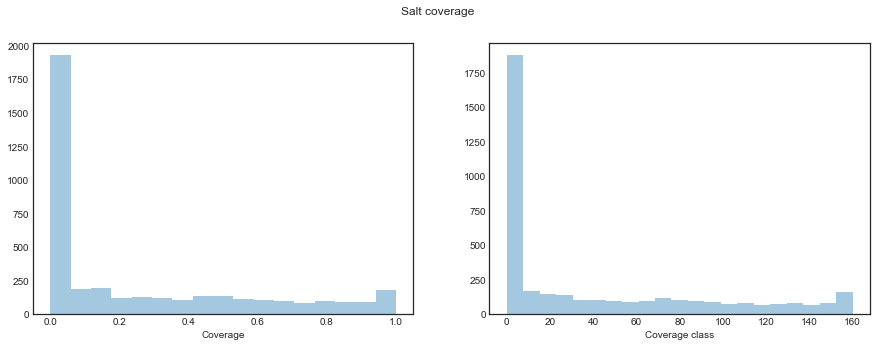

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=21, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

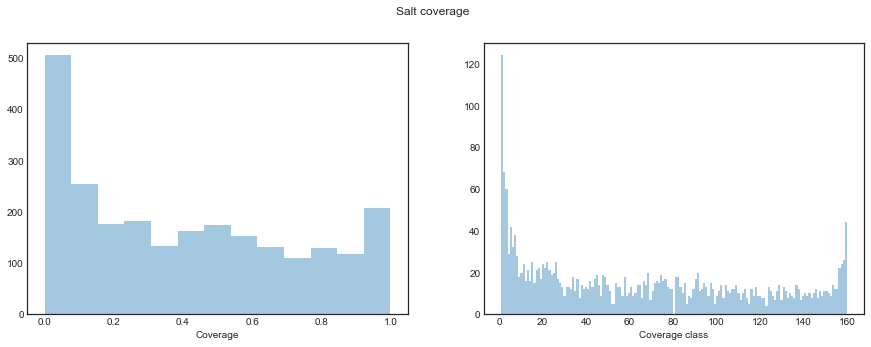

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df[train_df.coverage!=0].coverage, kde=False, ax=axs[0])
sns.distplot(train_df[train_df.coverage!=0].coverage_class, bins=161, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [61]:
max(train_df["coverage_class"])

80

## Нулевые картинки и маски

In [62]:
train_df["mask_is_empty"] = (train_df.masks.map(np.max) == 0)
train_df["img_is_empty"] = (train_df.images.map(np.max) == 0)
test_df["img_is_empty"] = (test_df.images.map(np.max) == 0)

c:\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
len(train_df), len(train_df[train_df.img_is_empty]), len(train_df[train_df.img_is_empty]) / len(train_df), \
  len(train_df[train_df.img_is_empty & ~train_df.mask_is_empty]), len(train_df[train_df.mask_is_empty]), \
  len(train_df[train_df.mask_is_empty])/len(train_df)

(4000, 80, 0.02, 0, 1562, 0.3905)

In [64]:
len(test_df), len(test_df[test_df.img_is_empty]), len(test_df[test_df.img_is_empty]) / len(test_df)

(18000, 430, 0.02388888888888889)

**Выводы**: 
1. Пустых картинок и в test и в train около 2%
2. У всех пустых картинок пустые маски
3. Пустых масок (без соли) довольно много (40%)

In [132]:
np.unique(train_df.coverage_class[train_df.mask_is_empty]), np.unique(train_df.coverage_class[~train_df.mask_is_empty])

(array([0], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64))

**Вывод**:   
    coverage_class == 0 эквивалентно mask_is_empty

## Полосатые маски

In [67]:
def mask_connected_components_info(m):
    return cv2.connectedComponentsWithStats(m.astype(np.uint8), 4)

train_df["mask_connected_components_info"] = train_df.masks.map(mask_connected_components_info)
# (count, masks, [(l,t,w,h,area)], [(x_centr, x_centr)])

In [88]:
x = train_df.mask_connected_components_info[2]
xm = x[1]
xm.shape
101*101, len(xm[xm==1]), len(xm[xm!=1]), 

(10201, 10133, 68)

In [123]:
def check_mask_is_strip(x):
    count = x.mask_connected_components_info[0]
    if count == 1:
        return False
    cnn_masks = x.mask_connected_components_info[1] # masks by ConnectedComponents
    rects = x.mask_connected_components_info[2]
    
    def check(i):
        r = rects[i]
        v = (r[1]==0 and r[3] == img_size_ori and r[4] == (r[2]*r[3]))
        return v
    strip_test = [check(i) for i in range(1, count)]
    res = max(strip_test)
    if min(strip_test) != res:
        return 2
    return res
    
train_df["mask_is_strip"] = train_df.apply(check_mask_is_strip, axis=1)    
# 0 - normal mask or no mask
# 1 - strip mask
# 2 - both strip and normal mask

In [126]:
train_df[train_df.mask_is_strip==2].index, len(train_df[train_df.mask_is_strip==2])

(Index(['458a05615e', '5bffe3b52f', '6fe4017680', '7b5d5d40fe', '4b72e35b8b'], dtype='object', name='id'),
 5)

In [128]:
len(train_df[train_df.mask_is_strip==1].index), len(train_df[train_df.mask_is_strip==1].index)/ len(train_df)

(113, 0.02825)

**Выводы**:   
полосатых масок около 3%, причем есть 5 картинок, где есть такие и такие маски вместе.

In [130]:
Признаки: глубина (ячейка),  полосатая маска, ДАТА ФАЙЛА и проч.  de95e861ac.png

SyntaxError: invalid syntax (<ipython-input-130-728248921abf>, line 1)

# Распределения

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\miniconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\miniconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5,1,'Depth distribution')

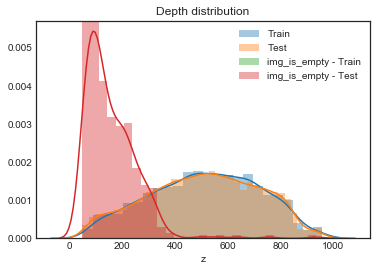

In [143]:
#Plotting the depth distributions¶
train_df
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
sns.distplot(train_df[train_df.img_is_empty].z, label="img_is_empty - Train")
sns.distplot(test_df[test_df.img_is_empty].z, label="img_is_empty - Test")
plt.legend()
plt.title("Depth distribution")

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

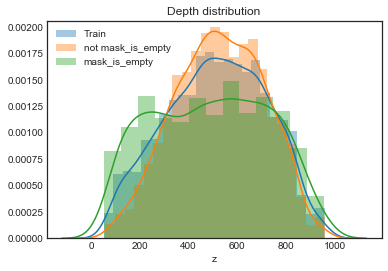

In [144]:
#Plotting the depth distributions¶
train_df
sns.distplot(train_df.z, label="Train")
sns.distplot(train_df[~train_df.mask_is_empty].z, label="not mask_is_empty")
sns.distplot(train_df[train_df.mask_is_empty].z, label="mask_is_empty")
plt.legend()
plt.title("Depth distribution")

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

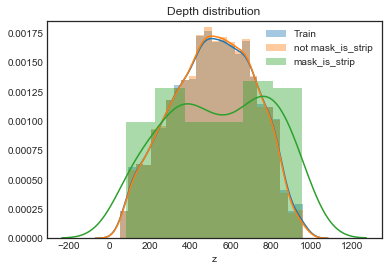

In [145]:
#Plotting the depth distributions¶
train_df
sns.distplot(train_df.z, label="Train")
sns.distplot(train_df[train_df.mask_is_strip==0].z, label="not mask_is_strip")
sns.distplot(train_df[train_df.mask_is_strip!=0].z, label="mask_is_strip")
plt.legend()
plt.title("Depth distribution")

# Убираем из трейна лишние кадры

In [142]:
train_df = train_df[~train_df.img_is_empty]
train_df.shape


(3920, 9)

# Стратификация


Наличие маски, полосатость, заполненине(10), Глубина (10)


In [164]:
def strat_levels(x, step):
    return [np.percentile(x,i) for i in range(step,100,step)]
def strat_bin(v, strat_levels):
    for i, sl in enumerate(strat_levels):
        if v <= sl :
            return i
    return len(strat_levels)


In [218]:
z_strat_levels = strat_levels(train_df.z, 10)
def z_strat(v):
    return strat_bin(v, z_strat_levels)
train_df["z_strat_class"] = train_df.z.map(z_strat)

In [219]:
coverage_strat_levels = strat_levels(train_df[~train_df.mask_is_empty].coverage, 10)
def coverage_strat(v):
    return strat_bin(v, coverage_strat_levels)
train_df["coverage_strat_class"] = train_df.coverage.map(coverage_strat)

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'coverage_strat_class')

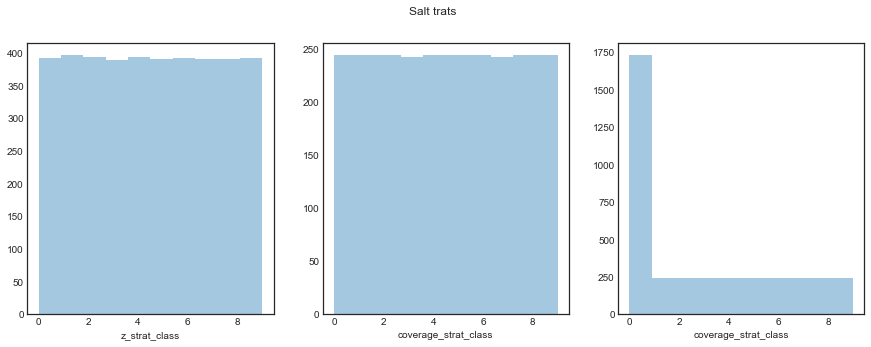

In [220]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(train_df.z_strat_class, bins=10, kde=False, ax=axs[0])
sns.distplot(train_df[~train_df.mask_is_empty].coverage_strat_class, bins=10, kde=False, ax=axs[1])
sns.distplot(train_df.coverage_strat_class, bins=10, kde=False, ax=axs[2])
plt.suptitle("Salt trats")
axs[0].set_xlabel("z_strat_class")
axs[1].set_xlabel("coverage_strat_class")

In [221]:
train_df['strat_value'] = train_df.apply(lambda r: (r.mask_is_empty, r.mask_is_strip, r.coverage_strat_class, r.z_strat_class) , axis = 1 )
#train_df['strat_value'] = train_df.apply(lambda r: (r.mask_is_empty, r.coverage_strat_class, r.z_strat_class) , axis = 1 )


# Разбиение

In [222]:
import sklearn
from sklearn.model_selection import KFold

In [223]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle = True, random_state = 241075)

In [238]:
folds = []
train_df['test_fold'] = -1
for i, (train_index, test_index) in enumerate(kf.split(train_df.index, groups = train_df.strat_value)):
    #print("TRAIN:", train_df.index[train_index], "TEST:", train_df.index[test_index])
    train_df.test_fold[test_index] = i
    folds.append({"train": train_df.index[train_index], "test": train_df.index[test_index]})
#folds


c:\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [240]:
train_df.test_fold

id
575d24d81d    3
a266a2a9df    4
75efad62c1    3
34e51dba6a    3
4875705fb0    3
782ae9b7e7    2
9842f69f8d    4
aa94cfb806    1
50d3073821    3
28f865caaa    1
b5e1371b3b    0
57e394bc67    1
b45ad3932e    2
ef51bbcde7    1
d4d34af4f7    2
302ea1ac81    0
40dcff68b3    2
7845115d01    3
3da729cae9    0
d67e3a11d8    2
b3396387a6    3
a5471f53d8    2
d27831fef2    1
7faea04242    3
9747413253    1
b9614348f4    3
4696bb53e6    0
fc250f574c    2
005b452274    1
02117a400e    2
             ..
93196366e1    0
16207869ba    4
44d745a704    1
711c478c93    2
84e23dba29    3
e73532b450    1
8329ec9395    0
7e7276d088    4
0e63d9a8b4    0
1d80de2ec9    3
919bc0e2ba    2
5cada3d3f1    2
0530b67189    1
fb44090bc7    2
3c1ed5cc1f    4
c7f54785b8    0
158765ed16    2
e8d8b35601    0
a7cfa30d35    2
917ef84e64    4
633c7d5c80    1
30082e87d9    1
f139be21a4    2
ac931ace49    2
cb36193e2f    3
9cbd5ddba4    3
caa039b231    4
1306fcee4c    2
48d81e93d9    3
edf1e6ac00    3
Name: test_fold, Leng

In [249]:
train_df.groupby(['z_strat_class','test_fold',]).count()

z  images  masks  coverage  coverage_class  \
z_strat_class test_fold                                                
0             0          76      76     76        76              76   
              1          82      82     82        82              82   
              2          72      72     72        72              72   
              3          86      86     86        86              86   
              4          76      76     76        76              76   
1             0          92      92     92        92              92   
              1          81      81     81        81              81   
              2          74      74     74        74              74   
              3          78      78     78        78              78   
              4          71      71     71        71              71   
2             0          75      75     75        75              75   
              1          85      85     85        85              85   
              2          81      81     81        81              81   
              3          74      74     74        74              74   
              4          79      79     79        79              79   
3             0          70      70     70        70              70   
              1          71      71     71        71              71   
              2          92      92     92        92              92   
              3          82      82     82        82              82   
              4          74      74     74        74              74   
4             0          78      78     78        78              78   
              1          73      73     73        73              73   
              2          79      79     79        79              79   
              3          80      80     80        80              80   
              4          84      84     84        84              84   
5             0          81      81     81        81              81   
              1          71      71     71        71              71   
              2          72      72     72        72              72   
              3          70      70     70        70              70   
              4          96      96     96        96              96   
6             0          84      84     84        84              84   
              1          92      92     92        92              92   
              2          75      75     75        75              75   
              3          71      71     71        71              71   
              4          70      70     70        70              70   
7             0          74      74     74        74              74   
              1          77      77     77        77              77   
              2          79      79     79        79              79   
              3          84      84     84        84              84   
              4          76      76     76        76              76   
8             0          82      82     82        82              82   
              1          77      77     77        77              77   
              2          77      77     77        77              77   
              3          86      86     86        86              86   
              4          69      69     69        69              69   
9             0          72      72     72        72              72   
              1          75      75     75        75              75   
              2          83      83     83        83              83   
              3          73      73     73        73              73   
              4          89      89     89        89              89   

                         mask_is_empty  img_is_empty  \
z_strat_class test_fold                                
0             0                     76            76   
              1                     82            82   
              2                     72            72   
 

In [250]:
train_df.groupby(['test_fold',]).count()

,z,images,masks,coverage,coverage_class,mask_is_empty,img_is_empty,mask_connected_components_info,mask_is_strip,z_strat_class,coverage_strat_class,strat_value
test_fold,,,,,,,,,,,,
0,784,784,784,784,784,784,784,784,784,784,784,784
1,784,784,784,784,784,784,784,784,784,784,784,784
2,784,784,784,784,784,784,784,784,784,784,784,784
3,784,784,784,784,784,784,784,784,784,784,784,784
4,784,784,784,784,784,784,784,784,784,784,784,784


In [257]:
train_df[["coverage", "coverage_class",
         "img_is_empty", "mask_is_empty", "mask_is_strip", 
         "z_strat_class", "coverage_strat_class", 'test_fold']].to_csv(basicpath+"/test_folds.csv", header=True )

In [254]:
basicpath

'T:/Kaggle_Data/Salt/'